## 이전에 진행했던 BMI데이터를 이용해 비만 정도를 판단하는 앙상블 모델을 구현해보자!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
# 랜덤포레스트 앙상블 모델 임포트
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier  # KNN 단일 모델

In [2]:
# 데이터 로드 및 학습, 평가, 문제, 정답 데이터로 분리하고 KNN모델로 학습 및 평가까지 진행해보세요.

In [25]:
data = pd.read_csv("data/bmi_500.csv")

# 문제 정답 분리
x = data.loc[ : , "Height":"Weight" ]
y = data.loc[ : , 'Label']

# 학습, 평가 분리
x_train = x.iloc[:350, :]
y_train = y.iloc[:350]
x_test = x.iloc[350:, :]
y_test = y.iloc[350:]

# 모델 로드
knn_model = KNeighborsClassifier(n_neighbors=10)
# 모델 학습
knn_model.fit(x_train, y_train)
# 모델 평가
knn_model.score(x_train, y_train)

0.9085714285714286

In [26]:
# test데이터로 평가
knn_model.score(x_test, y_test)

0.94

### 랜덤 포레스트 앙상블 모델 적용

In [27]:
forest_model = RandomForestClassifier(n_estimators=100,     # RF내 트리모델 개수
                                      max_features=5,       # 샘플 데이터의 최대 특성 개수
                                      max_depth=5,          # 트리의 최대 깊이
                                      random_state=11       # 랜덤 시드 값
                                     )
forest_model

RandomForestClassifier(max_depth=5, max_features=5, random_state=11)

In [28]:
forest_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, max_features=5, random_state=11)

In [30]:
forest_model.score(x_train, y_train)

0.9457142857142857

In [31]:
forest_model.score(x_test, y_test)

0.8466666666666667

In [33]:
train_list, test_list = [], []

for k in range(1,11,1) :
    forest_model = RandomForestClassifier(n_estimators=100,
                                          max_features=5,
                                          max_depth=k,
                                          random_state=11
                                         )
    forest_model.fit(x_train, y_train)

    train_score = forest_model.score(x_train, y_train)
    train_list.append(train_score)

    test_score = forest_model.score(x_test, y_test)
    test_list.append(test_score)

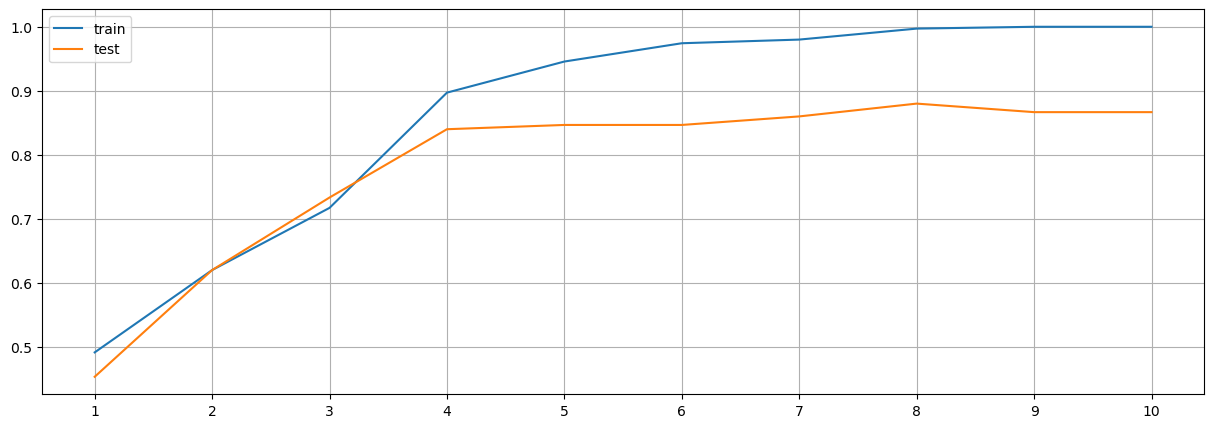

In [36]:
plt.figure(figsize = (15,5))
plt.plot(range(1,11), train_list, label = 'train')
plt.plot(range(1,11), test_list, label = 'test')
plt.xticks(range(1,11))

plt.legend()
plt.grid()
plt.show()

### XG부스팅 앙상블 모델 적용
- 외부라이브러리로 sklearn에서 지원하지 않음

In [37]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 6.8/150.0 MB 34.9 MB/s eta 0:00:05
   ---- ----------------------------------- 18.6/150.0 MB 45.5 MB/s eta 0:00:03
   -------- ------------------------------- 30.9/150.0 MB 50.6 MB/s eta 0:00:03
   ----------- ---------------------------- 44.0/150.0 MB 53.2 MB/s eta 0:00:02
   -------------- ------------------------- 54.8/150.0 MB 52.6 MB/s eta 0:00:02
   ----------------- ---------------------- 66.3/150.0 MB 52.7 MB/s eta 0:00:02
   -------------------- ------------------- 77.9/150.0 MB 53.3 MB/s eta 0:00:02
   ------------------------ --------------- 91.0/150.0 MB 54.6 MB/s eta 0:00:02
   -------------------------- ------------ 102.8/150.0 MB 55.4 MB/s eta 0:00:01
   ---------------------------- ---------- 108.0/150.0 MB 51.5 MB/s eta 0:00:01
   ------------------------------ -------- 115.9/150.0 MB 50.1 MB/s eta 0:00:01
   ---------------------------------- ---- 131.3/1

In [38]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

- XGboosting은 sklearn에서 제공하는 모델이 아니며 따라서 정답 데이터를 자동으로 수치화 시켜주지 않음

In [41]:
encoder = LabelEncoder()

# fit_transform : 데이터의 범위 학습 및 실제 변환까지 한번에 진행
y_train_encoded = encoder.fit_transform(y_train)

y_test_encoded = encoder.transform(y_test)
# y_test의 범위는 encoder가 학습하면 안됨(치팅의 위험)

In [43]:
xg_model = XGBClassifier()
xg_model.fit(x_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [44]:
xg_model.score(x_train, y_train_encoded)

1.0

In [45]:
xg_model.score(x_test, y_test_encoded)
# 하이퍼피라미터를 손대지 않았음에도 랜덤포레스트에 비해 평가데이터 결과가 더욱 좋음

0.9

## 보팅 앙상블 모델 적용

In [47]:
from sklearn.ensemble import VotingClassifier

In [49]:
voting_model = VotingClassifier(estimators=[('knn', knn_model),      # (모델명(임의로 지정), 모델 객체)
                                            ('forest', forest_model),
                                            ('xg',xg_model)
                                           ],
                                # 소프트 보팅으로 설정
                                voting='soft'
                               )
voting_model

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=10)),
                             ('forest',
                              RandomForestClassifier(max_depth=10,
                                                     max_features=5,
                                                     random_state=11)),
                             ('xg',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            ev...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

In [50]:
voting_model.fit(x_train, y_train)
voting_model.score(x_train, y_train)

0.9971428571428571

In [51]:
voting_model.score(x_test, y_test)

0.8933333333333333

- train와 test의 정확도 절대값이 높을수록 좋으나, 편차는 커질수록 안좋아짐
- 따라서 train과 test의 정확도 차이가 줄어들 수 있도록 데이터에 대한 가공을 신경쓰거나 모델 단에서의 하이퍼피라미터를 잘 튜닝하는 것이 성능을 높일 수 있는 길!

### 그리드 서치 적용
- 지정된 범위 내에서 최적의 하이퍼피라미터 값을 찾아주는 메커니즘

In [53]:
from sklearn.model_selection import GridSearchCV

In [56]:
# 하이퍼피라미터의 범위 지정
param_RF = {'n_estimators':range(50,200,50), 'max_depth':range(1,10,1)}

grid_search_RF = GridSearchCV(RandomForestClassifier(),
                              param_RF,
                              cv=5,         # 교차검증 폴드(셋트) 개수
                              verbose=2     # 0: 출력안함(디폴트), 1: 간단한 과정 출력, 2: 상세한 과정 출력
                             )
# 그리드 서치 실행
grid_search_RF.fit(x_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.2s
[CV] END ......................max_depth=1, n_e

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(50, 200, 50)},
             verbose=2)

In [57]:
print("최적 하이퍼피라미터 값 :", grid_search_RF.best_params_)
print("최고 정확도 점수 :", grid_search_RF.best_score_)
print("최고 성능 모델 :", grid_search_RF.best_estimator_)   # 현재 grid_search_RF에 저장된 모델이 최고 성능 모델

최적 하이퍼피라미터 값 : {'max_depth': 9, 'n_estimators': 50}
최고 정확도 점수 : 0.8742857142857143
최고 성능 모델 : RandomForestClassifier(max_depth=9, n_estimators=50)
